In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
##
## 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
## 2. Using CNN structure to extract geometry features (characteristics)
## 3. The time interval used to train is revolution 10 to 11.
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=200 # Number of filters (kernels) in Convolutional layer
n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
batch_size = 200 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# The number of revolution
t_lower = 10 # Lower limit of the interval of time
t_upper = 11 # Upper limit of the interval of time

In [4]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [5]:
# Case number: NACA 0018 without Gurney flap - case 0
# the others, which are Case 1,2,4,5,7,8,13,14,15,16,17,18,19,20,21

In [6]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

beta = beta[-1]

In [7]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [8]:
t_interval = 0.001
t_len = int((t_upper-t_lower) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps

In [9]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [10]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = cm_target[-10:-7]
n_data = len(cm_target) # Number of txt files from which the aerodynamic coefficients are extracted
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [11]:
cm_target

['case13cm_blade1.csv', 'case14cm_blade1.csv', 'case15cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x_time = t
    x_coord = total_coords.reshape((n_cases,2,55,1))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x_time: ", x_time.shape)
    print("Dimension - x_coordinates: ", x_coord.shape)
    print("Dimension - y: ", y.shape)
    
    return x_time, x_coord, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        cm_beUsed = cm[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 11, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = bb_imp
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = h[0]*np.ones(n_beta*t_len)
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
## AeroCNN-1: coordinates are replaced with grid data of 2*50 shape.
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    baseline_coord_high = data.iloc[0,:] # 1*50
    baseline_coord_low = data.iloc[1,:] # 1*50
    baseline_coord = np.vstack((baseline_coord_high, baseline_coord_low)).reshape((2,-1)) # 2*50
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [19]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j, betaValue in enumerate(beta):
            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    # flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords = np.vstack((flap_left, flap_right))
    flap_coords2 = np.zeros((n_cases*2,5))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [20]:
# Generating x, y and cm (for denormalizing)
x_time, x_coord, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (3000, 2)
Dimension - airfoil coordinates:  (6000, 50)
Dimension - coord with flaps:  (6000, 5)
Dimension - total coordinates:  (6000, 55)
Dimension - x_time:  (3000, 1)
Dimension - x_coordinates:  (3000, 2, 55, 1)
Dimension - y:  (3000, 1)


In [21]:
# x[:,0] -= 10
# x[:,0] /= 5
x_time -= 10

In [22]:
def dataset_split(x_time, x_coord, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_time_all, x_time_test, x_coord_all, x_coord_test, y_all, y_test, cm_all, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_time_train, x_time_val, x_coord_train, x_coord_val, y_train, y_val, cm_train, cm_val = train_test_split(x_time_all, x_coord_all, y_all, cm_all,
                                                                                                                  test_size=val_rate/(1-test_rate),
                                                                                                                  random_state=kwargs.get('random_state'))
        return x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test

In [23]:
x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x_time,x_coord, y, cm, test_rate, val_rate=val_rate,
                                                                                                                                                   validation=True, random_state=50)

In [24]:
def make_aerocnn1_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_time = tf.keras.Input(shape=1)
    input_coord = tf.keras.Input(shape=(2,55,1))
    
    # The convolutional layer
    x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1,
                                     padding='same', activation='relu',
                                     name='convLayer')(input_coord)
    x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)
    
    x_flat = tf.keras.layers.Flatten()(x_pool)
    x_concat = tf.keras.layers.Concatenate()([x_flat, input_time])

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(x_concat)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model([input_time, input_coord], output_data)
    
    return model

In [25]:
model = make_aerocnn1_model(num_layer=n_layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2, 55, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 55, 200)   1000        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 1, 27, 200)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten (Flatten)              (None, 5400)         0           ['max_pooling2d[0][0]']          
                                                                                              

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [27]:
model_directory = "D:\\TrainedModels\\20230102\\3Case(131415)"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [28]:
ckpt_name = model_directory + "20230102unsteady_AeroCNN1_3Case(131415)_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_kernels)+ "kernels_" +str(n_layers)+"FClayers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=400, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-05, min_lr=1e-05, verbose=1)

In [29]:
STEP_SIZE_TRAIN = len(x_time_train)//batch_size
VALIDATION_STEPS = len(x_time_val)//batch_size

In [30]:
start = datetime.datetime.now()
history = model.fit([x_time_train, x_coord_train], y_train, batch_size=batch_size,
                    validation_data=[[x_time_val, x_coord_val], y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
 4/10 [===========>..................] - ETA: 0s - loss: 0.1796 - rmse: 0.4236 
Epoch 1: val_loss improved from inf to 0.14892, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 3s 55ms/step - loss: 0.1690 - rmse: 0.4109 - val_loss: 0.1489 - val_rmse: 0.3857 - lr: 1.0000e-04
Epoch 2/10000
10/10 [==============================] - ETA: 0s - loss: 0.1035 - rmse: 0.3214
Epoch 2: val_loss improved from 0.14892 to 0.07444, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 20ms/step - loss: 0.1035 - rmse: 0.3214 - val_loss: 0.0744 - val_rmse: 0.2726 - lr: 1.0000e-04
Epoch 3/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0670 - rmse: 0.2585
Epoch 3: val_loss improved from 

Epoch 21/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0534 - rmse: 0.2307
Epoch 21: val_loss improved from 0.05516 to 0.05418, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 30ms/step - loss: 0.0524 - rmse: 0.2285 - val_loss: 0.0542 - val_rmse: 0.2324 - lr: 1.0000e-04
Epoch 22/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0539 - rmse: 0.2319
Epoch 22: val_loss improved from 0.05418 to 0.05300, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 30ms/step - loss: 0.0535 - rmse: 0.2311 - val_loss: 0.0530 - val_rmse: 0.2299 - lr: 1.0000e-04
Epoch 23/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0518 - rmse: 0.2273
Epoch 23: val_loss impro

Epoch 40/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0095 - rmse: 0.0965
Epoch 40: val_loss improved from 0.01029 to 0.00920, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 29ms/step - loss: 0.0095 - rmse: 0.0967 - val_loss: 0.0092 - val_rmse: 0.0951 - lr: 1.0000e-04
Epoch 41/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0083 - rmse: 0.0902
Epoch 41: val_loss improved from 0.00920 to 0.00749, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 29ms/step - loss: 0.0082 - rmse: 0.0898 - val_loss: 0.0075 - val_rmse: 0.0857 - lr: 1.0000e-04
Epoch 42/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0068 - rmse: 0.0814
Epoch 42: val_loss impro

10/10 [==============================] - 0s 31ms/step - loss: 0.0019 - rmse: 0.0416 - val_loss: 0.0017 - val_rmse: 0.0389 - lr: 1.0000e-04
Epoch 60/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0017 - rmse: 0.0398
Epoch 60: val_loss did not improve from 0.00166
10/10 [==============================] - 0s 18ms/step - loss: 0.0018 - rmse: 0.0402 - val_loss: 0.0017 - val_rmse: 0.0391 - lr: 1.0000e-04
Epoch 61/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0017 - rmse: 0.0392
Epoch 61: val_loss improved from 0.00166 to 0.00148, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 29ms/step - loss: 0.0017 - rmse: 0.0389 - val_loss: 0.0015 - val_rmse: 0.0365 - lr: 1.0000e-04
Epoch 62/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.0019 - rmse: 0.0412
Epoch 62: val_loss improved from 0.00148 to 0

 9/10 [==========================>...] - ETA: 0s - loss: 9.2488e-04 - rmse: 0.0279
Epoch 81: val_loss improved from 0.00084 to 0.00083, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 29ms/step - loss: 9.0092e-04 - rmse: 0.0275 - val_loss: 8.3200e-04 - val_rmse: 0.0262 - lr: 1.0000e-04
Epoch 82/10000
 9/10 [==========================>...] - ETA: 0s - loss: 9.1065e-04 - rmse: 0.0276
Epoch 82: val_loss improved from 0.00083 to 0.00080, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 29ms/step - loss: 9.2159e-04 - rmse: 0.0278 - val_loss: 8.0418e-04 - val_rmse: 0.0256 - lr: 1.0000e-04
Epoch 83/10000
 8/10 [=======================>......] - ETA: 0s - loss: 8.7312e-04 - rmse: 0.0269
Epoch 83: v

 8/10 [=======================>......] - ETA: 0s - loss: 7.4819e-04 - rmse: 0.0246
Epoch 104: val_loss did not improve from 0.00060
10/10 [==============================] - 0s 11ms/step - loss: 7.4963e-04 - rmse: 0.0246 - val_loss: 6.1030e-04 - val_rmse: 0.0216 - lr: 1.0000e-04
Epoch 105/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.3275e-04 - rmse: 0.0243
Epoch 105: val_loss did not improve from 0.00060
10/10 [==============================] - 0s 11ms/step - loss: 7.1470e-04 - rmse: 0.0239 - val_loss: 6.5625e-04 - val_rmse: 0.0226 - lr: 1.0000e-04
Epoch 106/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.5101e-04 - rmse: 0.0225
Epoch 106: val_loss did not improve from 0.00060
10/10 [==============================] - 0s 11ms/step - loss: 6.5686e-04 - rmse: 0.0226 - val_loss: 6.9689e-04 - val_rmse: 0.0235 - lr: 1.0000e-04
Epoch 107/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.6670e-04 - rmse: 0.0229
Epoch 107: val_loss improved fro

 8/10 [=======================>......] - ETA: 0s - loss: 5.1358e-04 - rmse: 0.0193
Epoch 128: val_loss improved from 0.00046 to 0.00043, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 22ms/step - loss: 5.0606e-04 - rmse: 0.0191 - val_loss: 4.3028e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 129/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.3653e-04 - rmse: 0.0172
Epoch 129: val_loss did not improve from 0.00043
10/10 [==============================] - 0s 12ms/step - loss: 4.3472e-04 - rmse: 0.0171 - val_loss: 4.3626e-04 - val_rmse: 0.0172 - lr: 1.0000e-04
Epoch 130/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.9568e-04 - rmse: 0.0188
Epoch 130: val_loss did not improve from 0.00043
10/10 [==============================] - 0s 12ms/step - loss: 5.0177e-04 - rmse: 0.0190 - val_loss: 7.0787e-04 - val_r

Epoch 155/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.2575e-04 - rmse: 0.0170
Epoch 155: val_loss did not improve from 0.00040
10/10 [==============================] - 0s 12ms/step - loss: 4.3265e-04 - rmse: 0.0172 - val_loss: 5.0075e-04 - val_rmse: 0.0190 - lr: 1.0000e-04
Epoch 156/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.8461e-04 - rmse: 0.0186
Epoch 156: val_loss did not improve from 0.00040
10/10 [==============================] - 0s 12ms/step - loss: 5.2964e-04 - rmse: 0.0198 - val_loss: 5.6553e-04 - val_rmse: 0.0207 - lr: 1.0000e-04
Epoch 157/10000
 8/10 [=======================>......] - ETA: 0s - loss: 7.5359e-04 - rmse: 0.0248
Epoch 157: val_loss did not improve from 0.00040
10/10 [==============================] - 0s 12ms/step - loss: 7.4282e-04 - rmse: 0.0246 - val_loss: 6.8453e-04 - val_rmse: 0.0234 - lr: 1.0000e-04
Epoch 158/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.2233e-04 - rmse: 0.0220
Epoch 158: val_l

 8/10 [=======================>......] - ETA: 0s - loss: 4.2351e-04 - rmse: 0.0170
Epoch 182: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 11ms/step - loss: 4.1018e-04 - rmse: 0.0166 - val_loss: 3.9134e-04 - val_rmse: 0.0160 - lr: 1.0000e-04
Epoch 183/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.0272e-04 - rmse: 0.0164
Epoch 183: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 11ms/step - loss: 4.0063e-04 - rmse: 0.0163 - val_loss: 4.7231e-04 - val_rmse: 0.0184 - lr: 1.0000e-04
Epoch 184/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.2736e-04 - rmse: 0.0171
Epoch 184: val_loss did not improve from 0.00038
10/10 [==============================] - 0s 11ms/step - loss: 4.3413e-04 - rmse: 0.0173 - val_loss: 4.4544e-04 - val_rmse: 0.0176 - lr: 1.0000e-04
Epoch 185/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.4891e-04 - rmse: 0.0177
Epoch 185: val_loss did not impr

 8/10 [=======================>......] - ETA: 0s - loss: 8.3892e-04 - rmse: 0.0266
Epoch 209: val_loss did not improve from 0.00037
10/10 [==============================] - 0s 12ms/step - loss: 8.4063e-04 - rmse: 0.0266 - val_loss: 9.2425e-04 - val_rmse: 0.0282 - lr: 1.0000e-04
Epoch 210/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.2737e-04 - rmse: 0.0282
Epoch 210: val_loss did not improve from 0.00037
10/10 [==============================] - 0s 12ms/step - loss: 8.9636e-04 - rmse: 0.0277 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.0000e-04
Epoch 211/10000
 8/10 [=======================>......] - ETA: 0s - loss: 9.8217e-04 - rmse: 0.0292
Epoch 211: val_loss did not improve from 0.00037
10/10 [==============================] - 0s 12ms/step - loss: 9.0426e-04 - rmse: 0.0278 - val_loss: 8.8303e-04 - val_rmse: 0.0274 - lr: 1.0000e-04
Epoch 212/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.3986e-04 - rmse: 0.0226
Epoch 212: val_loss did not improve 

Epoch 237/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.8235e-04 - rmse: 0.0159
Epoch 237: val_loss improved from 0.00037 to 0.00036, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 25ms/step - loss: 3.7947e-04 - rmse: 0.0159 - val_loss: 3.5855e-04 - val_rmse: 0.0152 - lr: 1.0000e-04
Epoch 238/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.2842e-04 - rmse: 0.0173
Epoch 238: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 12ms/step - loss: 4.3142e-04 - rmse: 0.0174 - val_loss: 3.8821e-04 - val_rmse: 0.0161 - lr: 1.0000e-04
Epoch 239/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.9897e-04 - rmse: 0.0165
Epoch 239: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 11ms/step - loss: 3.9300e-04 - rmse: 0.0163 - val_loss: 3.

 8/10 [=======================>......] - ETA: 0s - loss: 3.9918e-04 - rmse: 0.0166
Epoch 264: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 12ms/step - loss: 4.0305e-04 - rmse: 0.0167 - val_loss: 3.9148e-04 - val_rmse: 0.0163 - lr: 1.0000e-04
Epoch 265/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.1135e-04 - rmse: 0.0169
Epoch 265: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 11ms/step - loss: 4.1075e-04 - rmse: 0.0169 - val_loss: 4.8392e-04 - val_rmse: 0.0190 - lr: 1.0000e-04
Epoch 266/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.1799e-04 - rmse: 0.0171
Epoch 266: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 12ms/step - loss: 4.1347e-04 - rmse: 0.0170 - val_loss: 4.5336e-04 - val_rmse: 0.0181 - lr: 1.0000e-04
Epoch 267/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.1701e-04 - rmse: 0.0171
Epoch 267: val_loss did not impr

Epoch 292/10000
 8/10 [=======================>......] - ETA: 0s - loss: 6.0494e-04 - rmse: 0.0220
Epoch 292: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 12ms/step - loss: 6.3841e-04 - rmse: 0.0227 - val_loss: 8.3695e-04 - val_rmse: 0.0267 - lr: 1.0000e-04
Epoch 293/10000
 8/10 [=======================>......] - ETA: 0s - loss: 5.5273e-04 - rmse: 0.0208
Epoch 293: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 12ms/step - loss: 5.4950e-04 - rmse: 0.0207 - val_loss: 6.7933e-04 - val_rmse: 0.0236 - lr: 1.0000e-04
Epoch 294/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.8931e-04 - rmse: 0.0192
Epoch 294: val_loss did not improve from 0.00036
10/10 [==============================] - 0s 11ms/step - loss: 5.1644e-04 - rmse: 0.0199 - val_loss: 5.2555e-04 - val_rmse: 0.0201 - lr: 1.0000e-04
Epoch 295/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.8704e-04 - rmse: 0.0191
Epoch 295: val_l

Epoch 319/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.8374e-04 - rmse: 0.0191
Epoch 319: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 4.6206e-04 - rmse: 0.0185 - val_loss: 3.9709e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 320/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.6543e-04 - rmse: 0.0157
Epoch 320: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 3.6386e-04 - rmse: 0.0157 - val_loss: 3.7537e-04 - val_rmse: 0.0160 - lr: 1.0000e-04
Epoch 321/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.8371e-04 - rmse: 0.0163
Epoch 321: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 3.7160e-04 - rmse: 0.0159 - val_loss: 3.6265e-04 - val_rmse: 0.0156 - lr: 1.0000e-04
Epoch 322/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.3340e-04 - rmse: 0.0177
Epoch 322: val_l

Epoch 347/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.2283e-04 - rmse: 0.0175
Epoch 347: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 4.4669e-04 - rmse: 0.0182 - val_loss: 5.7061e-04 - val_rmse: 0.0213 - lr: 1.0000e-04
Epoch 348/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.5792e-04 - rmse: 0.0185
Epoch 348: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 4.6554e-04 - rmse: 0.0187 - val_loss: 4.4683e-04 - val_rmse: 0.0182 - lr: 1.0000e-04
Epoch 349/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.7058e-04 - rmse: 0.0188
Epoch 349: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 4.6728e-04 - rmse: 0.0187 - val_loss: 5.3601e-04 - val_rmse: 0.0205 - lr: 1.0000e-04
Epoch 350/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.0208e-04 - rmse: 0.0169
Epoch 350: val_l

 8/10 [=======================>......] - ETA: 0s - loss: 3.5079e-04 - rmse: 0.0154
Epoch 374: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 3.5519e-04 - rmse: 0.0155 - val_loss: 3.5598e-04 - val_rmse: 0.0156 - lr: 1.0000e-04
Epoch 375/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.5607e-04 - rmse: 0.0156
Epoch 375: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 3.5442e-04 - rmse: 0.0155 - val_loss: 3.6352e-04 - val_rmse: 0.0158 - lr: 1.0000e-04
Epoch 376/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.6359e-04 - rmse: 0.0158
Epoch 376: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 3.7124e-04 - rmse: 0.0161 - val_loss: 4.0292e-04 - val_rmse: 0.0170 - lr: 1.0000e-04
Epoch 377/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.7571e-04 - rmse: 0.0162
Epoch 377: val_loss did not impr

 8/10 [=======================>......] - ETA: 0s - loss: 3.7216e-04 - rmse: 0.0162
Epoch 401: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 3.8421e-04 - rmse: 0.0165 - val_loss: 4.8075e-04 - val_rmse: 0.0192 - lr: 1.0000e-04
Epoch 402/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.4923e-04 - rmse: 0.0184
Epoch 402: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 4.5290e-04 - rmse: 0.0185 - val_loss: 4.1202e-04 - val_rmse: 0.0174 - lr: 1.0000e-04
Epoch 403/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.0164e-04 - rmse: 0.0171
Epoch 403: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 3.8652e-04 - rmse: 0.0166 - val_loss: 4.5710e-04 - val_rmse: 0.0186 - lr: 1.0000e-04
Epoch 404/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.0614e-04 - rmse: 0.0172
Epoch 404: val_loss did not impr

Epoch 429/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.8217e-04 - rmse: 0.0165
Epoch 429: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 3.7979e-04 - rmse: 0.0165 - val_loss: 3.5729e-04 - val_rmse: 0.0158 - lr: 1.0000e-04
Epoch 430/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1660e-04 - rmse: 0.0144
Epoch 430: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 3.2206e-04 - rmse: 0.0146 - val_loss: 4.1062e-04 - val_rmse: 0.0174 - lr: 1.0000e-04
Epoch 431/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.5083e-04 - rmse: 0.0156
Epoch 431: val_loss did not improve from 0.00035
10/10 [==============================] - 0s 12ms/step - loss: 3.6369e-04 - rmse: 0.0160 - val_loss: 4.0956e-04 - val_rmse: 0.0174 - lr: 1.0000e-04
Epoch 432/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.9366e-04 - rmse: 0.0169
Epoch 432: val_l

10/10 [==============================] - 0s 21ms/step - loss: 3.1988e-04 - rmse: 0.0146 - val_loss: 3.3025e-04 - val_rmse: 0.0149 - lr: 5.0000e-05
Epoch 455/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9387e-04 - rmse: 0.0137
Epoch 455: val_loss improved from 0.00033 to 0.00033, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 31ms/step - loss: 3.0914e-04 - rmse: 0.0142 - val_loss: 3.2928e-04 - val_rmse: 0.0149 - lr: 5.0000e-05
Epoch 456/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1096e-04 - rmse: 0.0143
Epoch 456: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 12ms/step - loss: 3.1350e-04 - rmse: 0.0144 - val_loss: 3.4719e-04 - val_rmse: 0.0155 - lr: 5.0000e-05
Epoch 457/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0628e-04 - rmse: 0.0141
Epoc

Epoch 481/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.4977e-04 - rmse: 0.0156
Epoch 481: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 12ms/step - loss: 3.5033e-04 - rmse: 0.0156 - val_loss: 4.0588e-04 - val_rmse: 0.0173 - lr: 5.0000e-05
Epoch 482/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.7338e-04 - rmse: 0.0164
Epoch 482: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 12ms/step - loss: 3.9168e-04 - rmse: 0.0169 - val_loss: 5.4360e-04 - val_rmse: 0.0209 - lr: 5.0000e-05
Epoch 483/10000
 7/10 [====================>.........] - ETA: 0s - loss: 4.3094e-04 - rmse: 0.0180
Epoch 483: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 12ms/step - loss: 4.1336e-04 - rmse: 0.0175 - val_loss: 4.1313e-04 - val_rmse: 0.0175 - lr: 5.0000e-05
Epoch 484/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.9155e-04 - rmse: 0.0169
Epoch 484: val_l

Epoch 509/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3789e-04 - rmse: 0.0153
Epoch 509: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 12ms/step - loss: 3.2997e-04 - rmse: 0.0150 - val_loss: 3.6221e-04 - val_rmse: 0.0160 - lr: 5.0000e-05
Epoch 510/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3795e-04 - rmse: 0.0153
Epoch 510: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 12ms/step - loss: 3.3110e-04 - rmse: 0.0150 - val_loss: 3.7357e-04 - val_rmse: 0.0164 - lr: 5.0000e-05
Epoch 511/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.7378e-04 - rmse: 0.0164
Epoch 511: val_loss did not improve from 0.00033
10/10 [==============================] - 0s 12ms/step - loss: 3.8131e-04 - rmse: 0.0166 - val_loss: 3.9494e-04 - val_rmse: 0.0170 - lr: 5.0000e-05
Epoch 512/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.8390e-04 - rmse: 0.0167
Epoch 512: val_l

 8/10 [=======================>......] - ETA: 0s - loss: 3.3355e-04 - rmse: 0.0152
Epoch 536: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.3107e-04 - rmse: 0.0151 - val_loss: 3.3630e-04 - val_rmse: 0.0153 - lr: 5.0000e-05
Epoch 537/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1238e-04 - rmse: 0.0144
Epoch 537: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.0978e-04 - rmse: 0.0144 - val_loss: 3.3568e-04 - val_rmse: 0.0152 - lr: 5.0000e-05
Epoch 538/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1330e-04 - rmse: 0.0145
Epoch 538: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.0833e-04 - rmse: 0.0143 - val_loss: 3.2739e-04 - val_rmse: 0.0150 - lr: 5.0000e-05
Epoch 539/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1095e-04 - rmse: 0.0144
Epoch 539: val_loss did not impr

Epoch 564/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.2471e-04 - rmse: 0.0149
Epoch 564: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.2756e-04 - rmse: 0.0150 - val_loss: 3.5525e-04 - val_rmse: 0.0159 - lr: 5.0000e-05
Epoch 565/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1276e-04 - rmse: 0.0145
Epoch 565: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.1141e-04 - rmse: 0.0145 - val_loss: 3.3028e-04 - val_rmse: 0.0151 - lr: 5.0000e-05
Epoch 566/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.4153e-04 - rmse: 0.0155
Epoch 566: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.3840e-04 - rmse: 0.0154 - val_loss: 3.5838e-04 - val_rmse: 0.0160 - lr: 5.0000e-05
Epoch 567/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1791e-04 - rmse: 0.0147
Epoch 567: val_l

 8/10 [=======================>......] - ETA: 0s - loss: 3.3361e-04 - rmse: 0.0152
Epoch 591: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.2489e-04 - rmse: 0.0149 - val_loss: 3.2784e-04 - val_rmse: 0.0150 - lr: 5.0000e-05
Epoch 592/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3608e-04 - rmse: 0.0153
Epoch 592: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.3074e-04 - rmse: 0.0151 - val_loss: 3.2691e-04 - val_rmse: 0.0150 - lr: 5.0000e-05
Epoch 593/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.2692e-04 - rmse: 0.0150
Epoch 593: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.2529e-04 - rmse: 0.0150 - val_loss: 3.7888e-04 - val_rmse: 0.0167 - lr: 5.0000e-05
Epoch 594/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3677e-04 - rmse: 0.0153
Epoch 594: val_loss did not impr

 8/10 [=======================>......] - ETA: 0s - loss: 3.0307e-04 - rmse: 0.0142
Epoch 618: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.0072e-04 - rmse: 0.0142 - val_loss: 3.3307e-04 - val_rmse: 0.0153 - lr: 5.0000e-05
Epoch 619/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1843e-04 - rmse: 0.0148
Epoch 619: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.2294e-04 - rmse: 0.0149 - val_loss: 3.4760e-04 - val_rmse: 0.0157 - lr: 5.0000e-05
Epoch 620/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.2384e-04 - rmse: 0.0150
Epoch 620: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.2787e-04 - rmse: 0.0151 - val_loss: 4.0240e-04 - val_rmse: 0.0174 - lr: 5.0000e-05
Epoch 621/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.4982e-04 - rmse: 0.0158
Epoch 621: val_loss did not impr

 8/10 [=======================>......] - ETA: 0s - loss: 3.2916e-04 - rmse: 0.0152
Epoch 645: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.2640e-04 - rmse: 0.0151 - val_loss: 3.3757e-04 - val_rmse: 0.0154 - lr: 5.0000e-05
Epoch 646/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1434e-04 - rmse: 0.0147
Epoch 646: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.1220e-04 - rmse: 0.0146 - val_loss: 3.4284e-04 - val_rmse: 0.0156 - lr: 5.0000e-05
Epoch 647/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3647e-04 - rmse: 0.0154
Epoch 647: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.5769e-04 - rmse: 0.0161 - val_loss: 3.5075e-04 - val_rmse: 0.0159 - lr: 5.0000e-05
Epoch 648/10000
 8/10 [=======================>......] - ETA: 0s - loss: 4.0377e-04 - rmse: 0.0175
Epoch 648: val_loss did not impr

Epoch 673/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1125e-04 - rmse: 0.0146
Epoch 673: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.1004e-04 - rmse: 0.0146 - val_loss: 3.4826e-04 - val_rmse: 0.0158 - lr: 5.0000e-05
Epoch 674/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0588e-04 - rmse: 0.0144
Epoch 674: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.0250e-04 - rmse: 0.0143 - val_loss: 4.0012e-04 - val_rmse: 0.0174 - lr: 5.0000e-05
Epoch 675/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0248e-04 - rmse: 0.0143
Epoch 675: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.0415e-04 - rmse: 0.0144 - val_loss: 3.6130e-04 - val_rmse: 0.0162 - lr: 5.0000e-05
Epoch 676/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1281e-04 - rmse: 0.0147
Epoch 676: val_l

10/10 [==============================] - 0s 22ms/step - loss: 3.0348e-04 - rmse: 0.0143 - val_loss: 3.1699e-04 - val_rmse: 0.0148 - lr: 2.5000e-05
Epoch 701/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9674e-04 - rmse: 0.0141
Epoch 701: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 2.9365e-04 - rmse: 0.0140 - val_loss: 3.2633e-04 - val_rmse: 0.0151 - lr: 2.5000e-05
Epoch 702/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9953e-04 - rmse: 0.0142
Epoch 702: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 2.9745e-04 - rmse: 0.0141 - val_loss: 3.4718e-04 - val_rmse: 0.0158 - lr: 2.5000e-05
Epoch 703/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0660e-04 - rmse: 0.0145
Epoch 703: val_loss did not improve from 0.00032
10/10 [==============================] - 0s 12ms/step - loss: 3.0753e-04 - rmse: 0.0145 - val_loss: 3.7958e-04 - va

Epoch 728/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0675e-04 - rmse: 0.0145
Epoch 728: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.0510e-04 - rmse: 0.0144 - val_loss: 3.2864e-04 - val_rmse: 0.0152 - lr: 2.5000e-05
Epoch 729/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8287e-04 - rmse: 0.0136
Epoch 729: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.9863e-04 - rmse: 0.0142 - val_loss: 3.2585e-04 - val_rmse: 0.0151 - lr: 2.5000e-05
Epoch 730/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0701e-04 - rmse: 0.0145
Epoch 730: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.1044e-04 - rmse: 0.0146 - val_loss: 3.4532e-04 - val_rmse: 0.0158 - lr: 2.5000e-05
Epoch 731/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9027e-04 - rmse: 0.0139
Epoch 731: val_l

Epoch 756/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1515e-04 - rmse: 0.0148
Epoch 756: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.1908e-04 - rmse: 0.0149 - val_loss: 3.4828e-04 - val_rmse: 0.0159 - lr: 2.5000e-05
Epoch 757/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9318e-04 - rmse: 0.0140
Epoch 757: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.8999e-04 - rmse: 0.0139 - val_loss: 3.2756e-04 - val_rmse: 0.0152 - lr: 2.5000e-05
Epoch 758/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9998e-04 - rmse: 0.0143
Epoch 758: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.0244e-04 - rmse: 0.0144 - val_loss: 3.4527e-04 - val_rmse: 0.0158 - lr: 2.5000e-05
Epoch 759/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8767e-04 - rmse: 0.0138
Epoch 759: val_l

 8/10 [=======================>......] - ETA: 0s - loss: 3.0290e-04 - rmse: 0.0144
Epoch 783: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.0024e-04 - rmse: 0.0143 - val_loss: 3.3551e-04 - val_rmse: 0.0155 - lr: 2.5000e-05
Epoch 784/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0010e-04 - rmse: 0.0143
Epoch 784: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.0514e-04 - rmse: 0.0145 - val_loss: 3.3976e-04 - val_rmse: 0.0156 - lr: 2.5000e-05
Epoch 785/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0858e-04 - rmse: 0.0146
Epoch 785: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.9966e-04 - rmse: 0.0143 - val_loss: 3.2701e-04 - val_rmse: 0.0152 - lr: 2.5000e-05
Epoch 786/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8214e-04 - rmse: 0.0136
Epoch 786: val_loss did not impr

 8/10 [=======================>......] - ETA: 0s - loss: 3.0153e-04 - rmse: 0.0144
Epoch 810: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.9680e-04 - rmse: 0.0142 - val_loss: 3.4127e-04 - val_rmse: 0.0157 - lr: 2.5000e-05
Epoch 811/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7145e-04 - rmse: 0.0133
Epoch 811: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.7611e-04 - rmse: 0.0134 - val_loss: 3.2098e-04 - val_rmse: 0.0150 - lr: 2.5000e-05
Epoch 812/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9779e-04 - rmse: 0.0142
Epoch 812: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.0284e-04 - rmse: 0.0144 - val_loss: 3.3189e-04 - val_rmse: 0.0154 - lr: 2.5000e-05
Epoch 813/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9163e-04 - rmse: 0.0140
Epoch 813: val_loss did not impr

Epoch 838/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1494e-04 - rmse: 0.0148
Epoch 838: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.1610e-04 - rmse: 0.0149 - val_loss: 3.5169e-04 - val_rmse: 0.0160 - lr: 2.5000e-05
Epoch 839/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9519e-04 - rmse: 0.0142
Epoch 839: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.9845e-04 - rmse: 0.0143 - val_loss: 3.1368e-04 - val_rmse: 0.0148 - lr: 2.5000e-05
Epoch 840/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1824e-04 - rmse: 0.0149
Epoch 840: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.0935e-04 - rmse: 0.0146 - val_loss: 3.2522e-04 - val_rmse: 0.0152 - lr: 2.5000e-05
Epoch 841/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0510e-04 - rmse: 0.0145
Epoch 841: val_l

Epoch 866/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8395e-04 - rmse: 0.0138
Epoch 866: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.8461e-04 - rmse: 0.0138 - val_loss: 3.1978e-04 - val_rmse: 0.0150 - lr: 2.5000e-05
Epoch 867/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9885e-04 - rmse: 0.0143
Epoch 867: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.9645e-04 - rmse: 0.0142 - val_loss: 3.1931e-04 - val_rmse: 0.0150 - lr: 2.5000e-05
Epoch 868/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0390e-04 - rmse: 0.0145
Epoch 868: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.0217e-04 - rmse: 0.0144 - val_loss: 3.3844e-04 - val_rmse: 0.0156 - lr: 2.5000e-05
Epoch 869/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9413e-04 - rmse: 0.0141
Epoch 869: val_l

 8/10 [=======================>......] - ETA: 0s - loss: 3.1175e-04 - rmse: 0.0148
Epoch 893: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.1166e-04 - rmse: 0.0148 - val_loss: 3.2628e-04 - val_rmse: 0.0153 - lr: 2.5000e-05
Epoch 894/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.0486e-04 - rmse: 0.0145
Epoch 894: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.1813e-04 - rmse: 0.0150 - val_loss: 3.1303e-04 - val_rmse: 0.0148 - lr: 2.5000e-05
Epoch 895/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.3676e-04 - rmse: 0.0156
Epoch 895: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.2813e-04 - rmse: 0.0153 - val_loss: 3.1902e-04 - val_rmse: 0.0150 - lr: 2.5000e-05
Epoch 896/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8899e-04 - rmse: 0.0140
Epoch 896: val_loss did not impr

 8/10 [=======================>......] - ETA: 0s - loss: 3.0207e-04 - rmse: 0.0145
Epoch 920: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.9238e-04 - rmse: 0.0141 - val_loss: 3.2588e-04 - val_rmse: 0.0153 - lr: 1.2500e-05
Epoch 921/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7876e-04 - rmse: 0.0136
Epoch 921: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.8295e-04 - rmse: 0.0138 - val_loss: 3.1433e-04 - val_rmse: 0.0149 - lr: 1.2500e-05
Epoch 922/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8720e-04 - rmse: 0.0139
Epoch 922: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.8779e-04 - rmse: 0.0140 - val_loss: 3.2917e-04 - val_rmse: 0.0154 - lr: 1.2500e-05
Epoch 923/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8326e-04 - rmse: 0.0138
Epoch 923: val_loss did not impr

Epoch 947/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9046e-04 - rmse: 0.0141
Epoch 947: val_loss improved from 0.00031 to 0.00031, saving model to D:\TrainedModels\20230102\3Case(131415)20230102unsteady_AeroCNN1_3Case(131415)_val_0.2_test0.1_200kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 22ms/step - loss: 2.8720e-04 - rmse: 0.0139 - val_loss: 3.0795e-04 - val_rmse: 0.0147 - lr: 1.2500e-05
Epoch 948/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7239e-04 - rmse: 0.0134
Epoch 948: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.7309e-04 - rmse: 0.0134 - val_loss: 3.2931e-04 - val_rmse: 0.0154 - lr: 1.2500e-05
Epoch 949/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8755e-04 - rmse: 0.0140
Epoch 949: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.7990e-04 - rmse: 0.0137 - val_loss: 3.

 8/10 [=======================>......] - ETA: 0s - loss: 2.7499e-04 - rmse: 0.0135
Epoch 973: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.7925e-04 - rmse: 0.0137 - val_loss: 3.4100e-04 - val_rmse: 0.0158 - lr: 1.2500e-05
Epoch 974/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9673e-04 - rmse: 0.0143
Epoch 974: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.9629e-04 - rmse: 0.0143 - val_loss: 3.1060e-04 - val_rmse: 0.0148 - lr: 1.2500e-05
Epoch 975/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8957e-04 - rmse: 0.0140
Epoch 975: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.0035e-04 - rmse: 0.0144 - val_loss: 3.2034e-04 - val_rmse: 0.0151 - lr: 1.2500e-05
Epoch 976/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9151e-04 - rmse: 0.0141
Epoch 976: val_loss did not impr

Epoch 1001/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8846e-04 - rmse: 0.0140
Epoch 1001: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.9015e-04 - rmse: 0.0141 - val_loss: 3.1513e-04 - val_rmse: 0.0149 - lr: 1.2500e-05
Epoch 1002/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9253e-04 - rmse: 0.0142
Epoch 1002: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.8609e-04 - rmse: 0.0139 - val_loss: 3.3893e-04 - val_rmse: 0.0157 - lr: 1.2500e-05
Epoch 1003/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0155e-04 - rmse: 0.0145
Epoch 1003: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.0232e-04 - rmse: 0.0145 - val_loss: 3.2206e-04 - val_rmse: 0.0152 - lr: 1.2500e-05
Epoch 1004/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.6866e-04 - rmse: 0.0133
Epoch 100

Epoch 1029/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8751e-04 - rmse: 0.0140
Epoch 1029: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.9121e-04 - rmse: 0.0141 - val_loss: 3.2224e-04 - val_rmse: 0.0152 - lr: 1.2500e-05
Epoch 1030/10000
 8/10 [=======================>......] - ETA: 0s - loss: 3.1350e-04 - rmse: 0.0149
Epoch 1030: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 3.0889e-04 - rmse: 0.0147 - val_loss: 3.1638e-04 - val_rmse: 0.0150 - lr: 1.2500e-05
Epoch 1031/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9761e-04 - rmse: 0.0143
Epoch 1031: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.9187e-04 - rmse: 0.0141 - val_loss: 3.1542e-04 - val_rmse: 0.0149 - lr: 1.2500e-05
Epoch 1032/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8329e-04 - rmse: 0.0138
Epoch 103

Epoch 1057/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7124e-04 - rmse: 0.0134
Epoch 1057: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.7831e-04 - rmse: 0.0137 - val_loss: 3.0907e-04 - val_rmse: 0.0147 - lr: 1.2500e-05
Epoch 1058/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8674e-04 - rmse: 0.0140
Epoch 1058: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.7868e-04 - rmse: 0.0137 - val_loss: 3.2468e-04 - val_rmse: 0.0153 - lr: 1.2500e-05
Epoch 1059/10000
 7/10 [====================>.........] - ETA: 0s - loss: 3.0066e-04 - rmse: 0.0145
Epoch 1059: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.8968e-04 - rmse: 0.0141 - val_loss: 3.0797e-04 - val_rmse: 0.0147 - lr: 1.2500e-05
Epoch 1060/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7943e-04 - rmse: 0.0137
Epoch 106

Epoch 1085/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8820e-04 - rmse: 0.0140
Epoch 1085: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.8699e-04 - rmse: 0.0140 - val_loss: 3.1275e-04 - val_rmse: 0.0149 - lr: 1.2500e-05
Epoch 1086/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.7951e-04 - rmse: 0.0137
Epoch 1086: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.7825e-04 - rmse: 0.0137 - val_loss: 3.2749e-04 - val_rmse: 0.0154 - lr: 1.2500e-05
Epoch 1087/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.8064e-04 - rmse: 0.0138
Epoch 1087: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.8510e-04 - rmse: 0.0139 - val_loss: 3.0872e-04 - val_rmse: 0.0147 - lr: 1.2500e-05
Epoch 1088/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7689e-04 - rmse: 0.0136
Epoch 108

Epoch 1112/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.9011e-04 - rmse: 0.0141
Epoch 1112: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.8230e-04 - rmse: 0.0138 - val_loss: 3.0564e-04 - val_rmse: 0.0146 - lr: 1.2500e-05
Epoch 1113/10000
 7/10 [====================>.........] - ETA: 0s - loss: 2.7795e-04 - rmse: 0.0137
Epoch 1113: val_loss did not improve from 0.00031
10/10 [==============================] - 0s 12ms/step - loss: 2.7854e-04 - rmse: 0.0137 - val_loss: 3.0736e-04 - val_rmse: 0.0147 - lr: 1.2500e-05
Epoch 1114/10000
 8/10 [=======================>......] - ETA: 0s - loss: 2.8615e-04 - rmse: 0.0140Restoring model weights from the end of the best epoch: 714.

Epoch 1114: val_loss did not improve from 0.00031

Epoch 1114: ReduceLROnPlateau reducing learning rate to 1e-05.
10/10 [==============================] - 0s 13ms/step - loss: 2.8381e-04 - rmse: 0.0139 - val_loss: 3.3473e-04 - val_rmse: 0.0156 -

In [31]:
time = end - start
print("Training time:", time)

Training time: 0:02:27.340416


In [32]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20230102_AeroCNN1_3Case(131415)_WithParameters\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_kernels)+"kernels_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

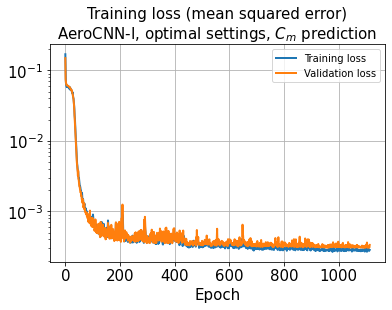

In [33]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

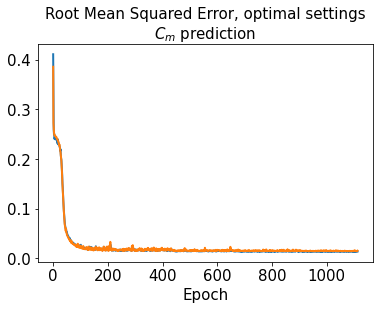

In [34]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

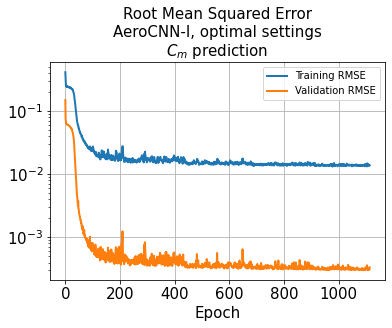

In [35]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [36]:
train_results = model.evaluate([x_time_train, x_coord_train], y_train)

66/66 [==============================] - 0s 5ms/step - loss: 2.8389e-04 - rmse: 0.0137


In [37]:
val_results = model.evaluate([x_time_val, x_coord_val], y_val)

19/19 [==============================] - 0s 6ms/step - loss: 3.1366e-04 - rmse: 0.0147


In [38]:
test_results = model.evaluate([x_time_test, x_coord_test], y_test)

10/10 [==============================] - 0s 7ms/step - loss: 3.0421e-04 - rmse: 0.0144


In [39]:
decoded_train_ = model.predict([x_time_train, x_coord_train])
decoded_val_ = model.predict([x_time_val, x_coord_val])
decoded_test_ = model.predict([x_time_test, x_coord_test])

10/10 [==============================] - 0s 3ms/step


In [40]:
def define_index(y_total, y_partial):
    return np.unique(np.where(np.isin(y_total, y_partial)))

In [41]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [42]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [43]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real) * np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real + y_pred)

In [44]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [45]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.031340376332712035
1.1851547328772656


In [46]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.03282845169063853
1.2748996886353283


In [47]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.035102254331716515
1.2549060938662178


In [48]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [49]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [50]:
model_directory = "D:\\TrainedModels\\20230102"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221230unsteady_AeroCNN1_3Case(131415)_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels)+"kernels_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [51]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [52]:
os.chdir(storage_dir)

In [53]:
l2_error_train_list = []
for i in range(0, len(x_time_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [54]:
l2_error_val_list = []
for i in range(0, len(x_time_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [55]:
l2_error_test_list = []
for i in range(0, len(x_time_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [56]:
mape_train_list = []
for i in range(0, len(x_time_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [57]:
mape_val_list = []
for i in range(0, len(x_time_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [58]:
mape_test_list = []
for i in range(0, len(x_time_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [59]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

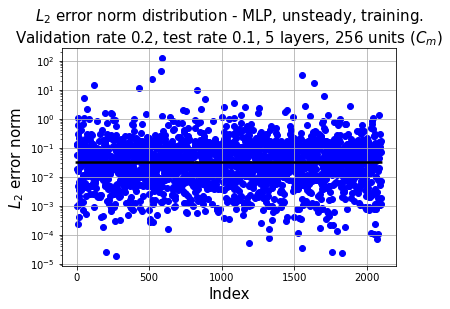

In [60]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

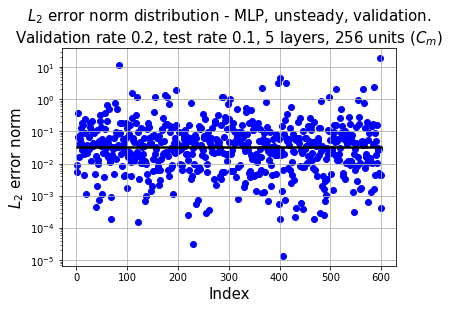

In [61]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

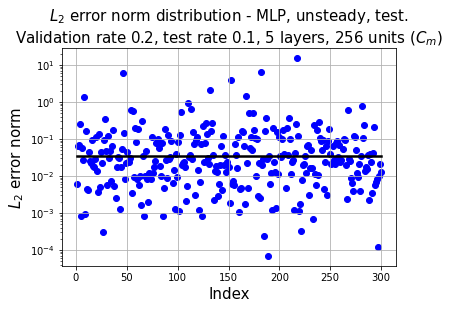

In [62]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [63]:
predicted = model.predict([x_time, x_coord])

94/94 [==============================] - 0s 3ms/step


In [64]:
tTrain = x_time[index_train] + 10
tVal = x_time[index_val] + 10
tTest = x_time[index_test] + 10

In [65]:
max(predicted)

array([0.9846883], dtype=float32)

In [66]:
print(l2_error(predicted, y))

0.032007897874501694


In [67]:
# Each set of data in sorted order
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [68]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [69]:
t

array([[0.   ],
       [0.001],
       [0.002],
       ...,
       [0.997],
       [0.998],
       [0.999]])

In [73]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [71]:
x_time += 10

L2 error of Cm: 0.0318


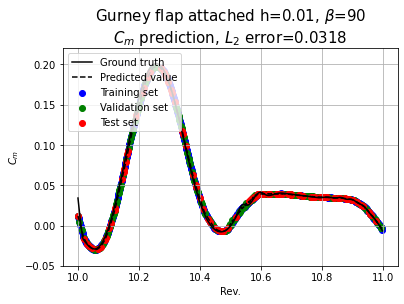

L2 error of Cm: 0.0416


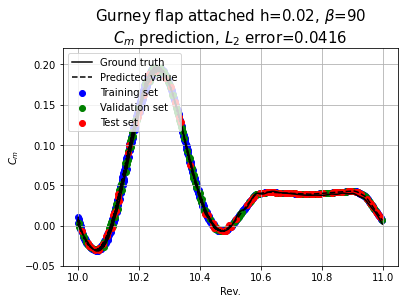

L2 error of Cm: 0.0174


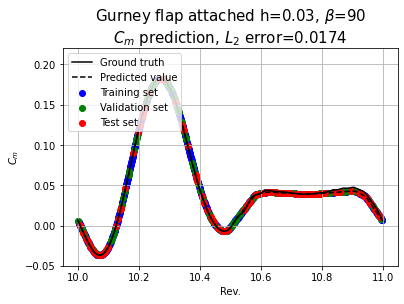

In [74]:
h = [0.01, 0.02, 0.03]
beta = [90, 90, 90]
for i in range(0,3):
    #Index from each dataset in sorted order
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [77]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'r--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.xlim([10.17, 10.23])
    plt.ylim([0.1, 0.15])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0318


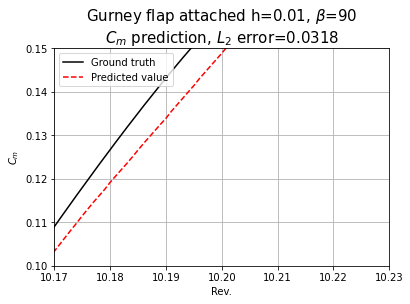

L2 error of Cm: 0.0416


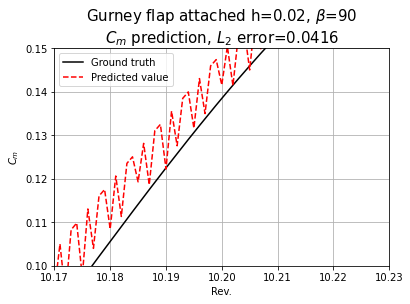

L2 error of Cm: 0.0174


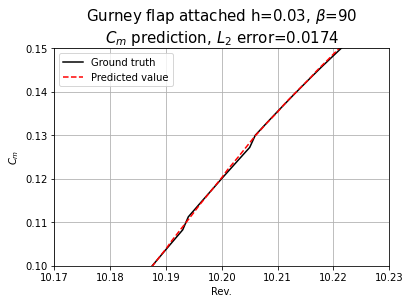

In [78]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [ ]:
for i in range(0,1):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)

    # Cm graph plot
    ## Training dataset
    plt.plot(t, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t, denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Validation dataset
    plt.plot(t, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t, denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Test dataset
    plt.plot(t, denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t, denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

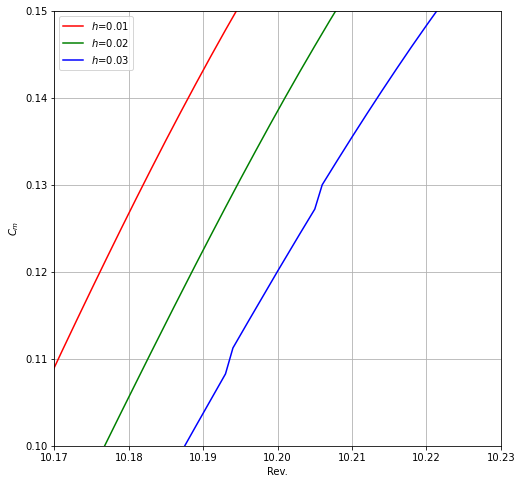

In [82]:
plt.figure(figsize=(8,8))
plt.plot(t[:1000], cm[:1000], 'r-', label='$h$=0.01')
plt.plot(t[:1000], cm[1000:2000], 'g-', label='$h$=0.02')
plt.plot(t[:1000], cm[2000:3000], 'b-', label='$h$=0.03')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
#plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
plt.xlim([10.17, 10.23])
plt.ylim([0.1, 0.15])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()